In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.__version__

'2.0.0'

In [3]:
ds = tfds.load('cifar10', shuffle_files=True)

In [4]:
def normalize_image(ele):
    image = ele['image']
    label = ele['label']
    paddings = tf.constant([[4,4], [4,4], [0,0]])
  
    image = tf.pad(image, paddings, 'CONSTANT')
    image = tf.image.random_crop(image, size = [32,32,3])
    #image -= tf.reduce_mean(image) 
    image = (image - tf.reduce_min(image))/(tf.reduce_max(image)-tf.reduce_min(image))
    return image, label


ds_train = ds['train'].map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).repeat().shuffle(100).batch(128).prefetch(1)
ds_test = ds['test'].map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).repeat().shuffle(100).batch(128).prefetch(1)


In [5]:
print(ds['train'])

<_OptionsDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [6]:
ds_test_iterator = iter(ds_test)

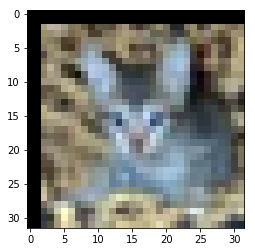

In [7]:
x,y = next(ds_test_iterator)
#print(x)
plt.imshow(x.numpy()[0])

In [8]:
def conv2D(x, filters, kernel=(3,3), strides=(1,1), activation=tf.nn.relu, use_bias=False):
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel, strides=strides, use_bias=use_bias, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation is not None:
        x = tf.keras.layers.Activation(activation)(x)
    return x

def mini_block(x, trips = [16, 16] , first = False):
    if first:
        x = conv2D(x, trips[0], kernel =  (3,3), strides = (2,2))
    else:
        x = conv2D(x, trips[0], kernel = (3,3), strides = (1,1))
    x = conv2D(x, trips[1], kernel = (3,3), strides = (1,1))
    return x 

def mesa_block(x, trips = [16,16], repeats = 36, downsample = True):
    prev = x
    for r in range(repeats):
        if r == 0 and downsample:
            prev = conv2D(prev, trips[1], kernel = (1,1), strides = (2,2), activation = None)
            x = mini_block(x, trips = trips, first = True)
            x = tf.keras.layers.Add()([x,prev])
        if r == 0 and not downsample:
            prev = x
            x = mini_block(x, trips = trips)
            x = tf.keras.layers.Add()([x,prev])
        else:
            prev = x
            x = mini_block(x, trips = trips)
            x = tf.keras.layers.Add()([x, prev])
    return x 

In [9]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = conv2D(inputs, 16, kernel=(3,3), strides=(1,1),)

### Block 1
x = mesa_block(x, trips=[16,16], repeats=18, downsample=False)

### Block 2
x = mesa_block(x, trips=[32, 32], repeats=18)

### Block 3
x = mesa_block(x, trips=[64,64], repeats=18)



x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x) #logits 
resnet110 = tf.keras.Model(inputs, x)
resnet110.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
step = tf.Variable(0, trainable=False)
boundaries = [1, 82, 123]
values = [0.01, 0.1, 0.1/10, 0.1/100]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

learning_rate = learning_rate_fn(step)

In [11]:
resnet110.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet110.fit(ds_train, epochs=165, steps_per_epoch=390, validation_data=ds_test, validation_steps=10)

Train for 390 steps, validate for 10 steps
Epoch 1/165
390/390 [==============================] - 82s 210ms/step - loss: 2.4743 - accuracy: 0.1917 - val_loss: 2.6098 - val_accuracy: 0.1914
Epoch 2/165
390/390 [==============================] - 59s 152ms/step - loss: 2.0326 - accuracy: 0.2186 - val_loss: 2.2263 - val_accuracy: 0.2180
Epoch 4/165
390/390 [==============================] - 60s 154ms/step - loss: 2.0108 - accuracy: 0.2269 - val_loss: 2.3150 - val_accuracy: 0.2352
Epoch 5/165
390/390 [==============================] - 61s 155ms/step - loss: 1.9500 - accuracy: 0.2539 - val_loss: 2.2694 - val_accuracy: 0.2172
Epoch 7/165
390/390 [==============================] - 60s 153ms/step - loss: 1.8982 - accuracy: 0.2763 - val_loss: 2.0610 - val_accuracy: 0.2539
Epoch 8/165
390/390 [==============================] - 61s 155ms/step - loss: 1.8441 - accuracy: 0.3049 - val_loss: 2.0409 - val_accuracy: 0.2711
Epoch 9/165
390/390 [==============================] - 60s 154ms/step - loss: 1.7